In [3]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense,LSTM, TimeDistributed, Flatten, MaxPooling1D,Conv1D,Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso,ElasticNet,HuberRegressor,PassiveAggressiveRegressor,SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor,ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor,BaggingRegressor,RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
pd.set_option('display.float_format', lambda x: '%.3f' % x)

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
pip install statsmodels



     ---------------------------------------- 9.9/9.9 MB 4.5 MB/s eta 0:00:00
     -------------------------------------- 232.9/232.9 KB 2.9 MB/s eta 0:00:00


You should consider upgrading via the 'C:\Users\Onur Beyhatun\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [4]:
train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')
items = pd.read_csv('items.csv')
items_cat = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')

In [5]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.000,1.000
1,03.01.2013,0,25,2552,899.000,1.000
2,05.01.2013,0,25,2552,899.000,-1.000
3,06.01.2013,0,25,2554,1709.050,1.000
4,15.01.2013,0,25,2555,1099.000,1.000


In [6]:
test.head()


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [7]:
shops.head()


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [8]:
items.head()


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [9]:
train.describe()


,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849.000,2935849.000,2935849.000,2935849.000,2935849.000
mean,14.570,33.002,10197.227,890.853,1.243
std,9.423,16.227,6324.297,1729.800,2.619
min,0.000,0.000,0.000,-1.000,-22.000
25%,7.000,22.000,4476.000,249.000,1.000
50%,14.000,31.000,9343.000,399.000,1.000
75%,23.000,47.000,15684.000,999.000,1.000
max,33.000,59.000,22169.000,307980.000,2169.000


In [10]:
train.isnull().sum()


date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [11]:
train[train.duplicated(keep = False)]


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76961,05.01.2013,0,54,20130,149.000,1.000
76962,05.01.2013,0,54,20130,149.000,1.000
1435365,23.02.2014,13,50,3423,999.000,1.000
1435367,23.02.2014,13,50,3423,999.000,1.000
1496765,23.03.2014,14,21,3423,999.000,1.000
1496766,23.03.2014,14,21,3423,999.000,1.000
1671872,01.05.2014,16,50,3423,999.000,1.000
1671873,01.05.2014,16,50,3423,999.000,1.000
1866322,12.07.2014,18,25,3423,999.000,1.000
1866340,12.07.2014,18,25,3423,999.000,1.000


In [12]:
train.drop_duplicates(keep = 'first',inplace = True)


In [13]:
train.date = pd.to_datetime(train.date, format = '%d.%m.%Y' )
# train = train.set_index('date')

train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.000,1.000
1,2013-01-03,0,25,2552,899.000,1.000
2,2013-01-05,0,25,2552,899.000,-1.000
3,2013-01-06,0,25,2554,1709.050,1.000
4,2013-01-15,0,25,2555,1099.000,1.000


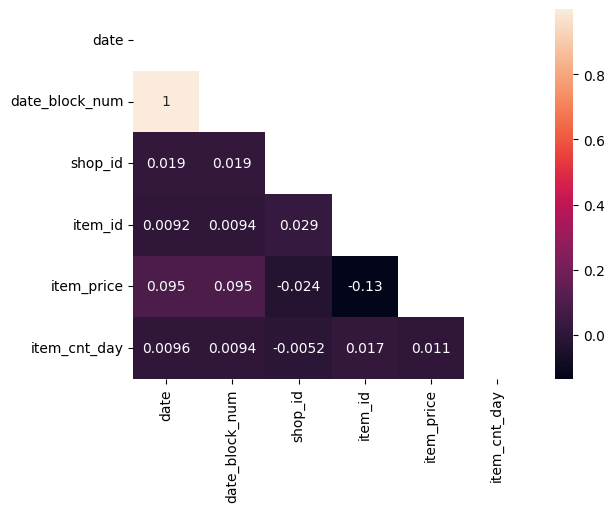

In [14]:
mask = np.triu(np.ones_like(train.corr(),dtype = bool))
f,ax = plt.subplots()
sns.heatmap(train.corr(),mask = mask,annot = True);

In [15]:
train_1 = train.copy()
train_1 = train_1.set_index('date').sort_index()
train_1

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date,,,,,
2013-01-01,0,18,16182,1619.000,1.000
2013-01-01,0,54,12355,399.000,1.000
2013-01-01,0,54,16877,149.000,1.000
2013-01-01,0,27,15435,499.000,1.000
2013-01-01,0,54,19678,149.000,1.000
...,...,...,...,...,...
2015-10-31,33,50,8918,28.000,1.000
2015-10-31,33,6,8116,1699.000,1.000
2015-10-31,33,37,2423,499.000,3.000


Text(0.5, 0, 'Year - Month')

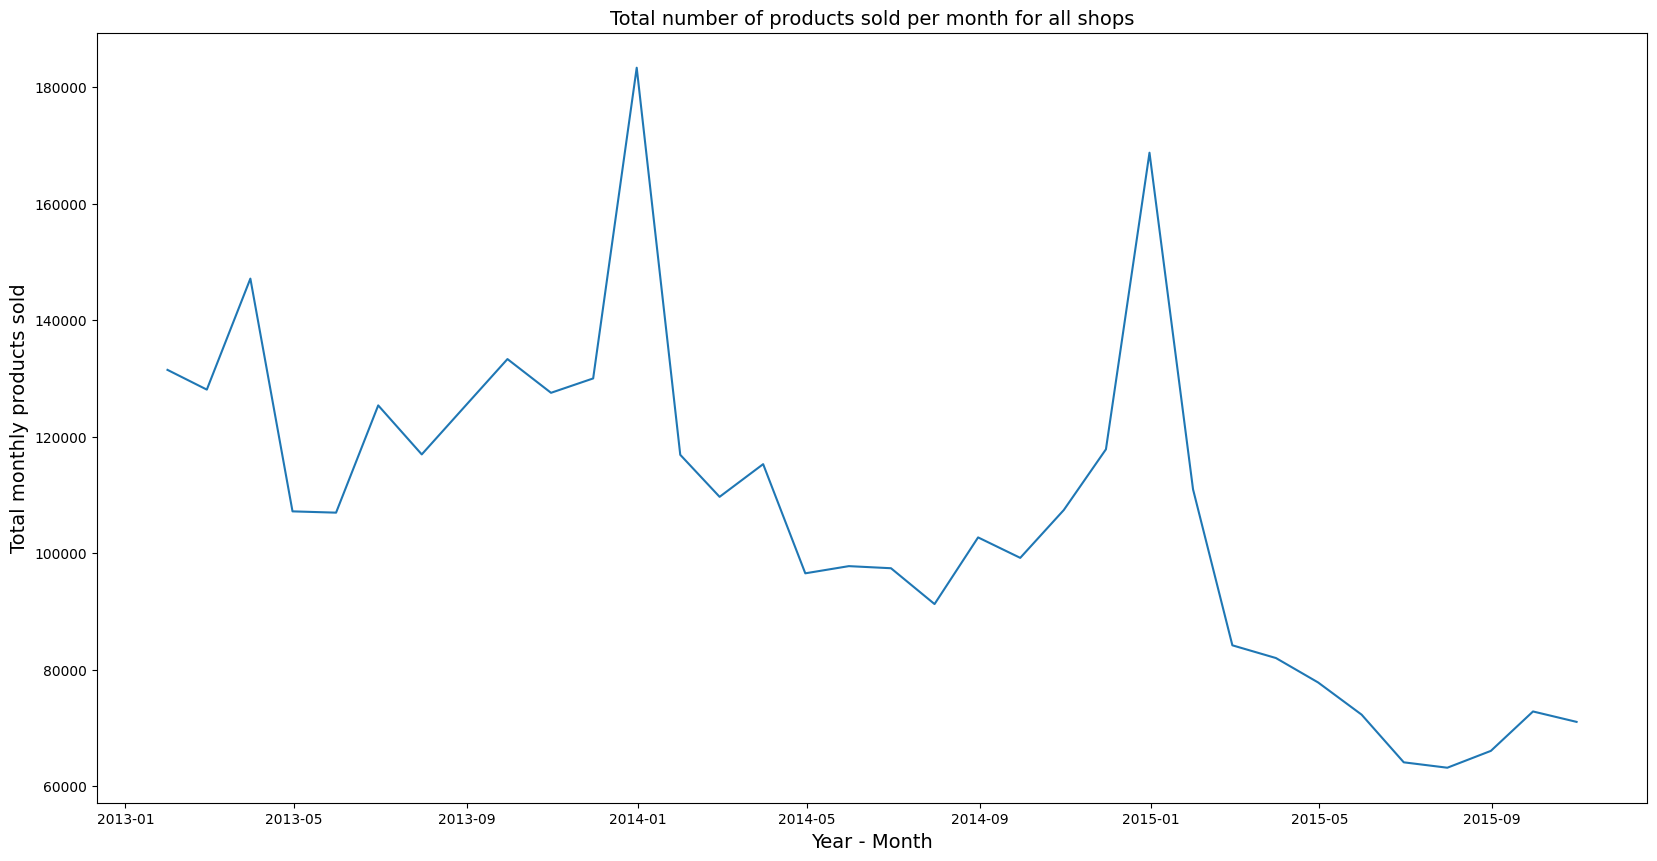

In [16]:
fig,ax = plt.subplots(figsize = (20,10))
ax.plot(train_1.resample('M').agg({'item_price':'mean','item_cnt_day':'sum'})['item_cnt_day'])
ax.set_title('Total number of products sold per month for all shops',fontsize = 14)
ax.set_ylabel('Total monthly products sold',fontsize = 14)
ax.set_xlabel('Year - Month',fontsize = 14)

<Axes: ylabel='item_cnt_day'>

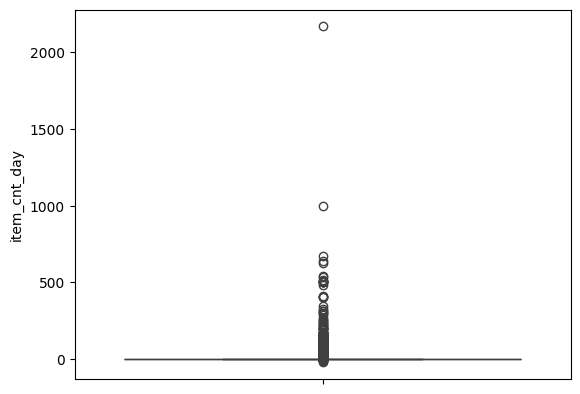

In [17]:
sns.boxplot(train.item_cnt_day)


In [18]:
train[train.item_cnt_day > 2000]


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2909818,2015-10-28,33,12,11373,0.909,2169.000


<Axes: ylabel='item_cnt_day'>

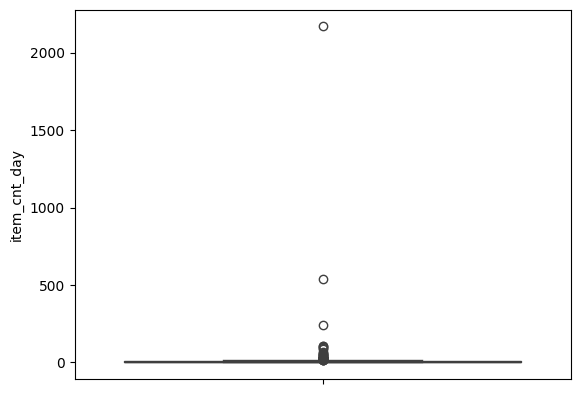

In [19]:
sns.boxplot(train[train.item_id == 11373]["item_cnt_day"])


In [20]:
train.drop(2909818,inplace = True)


<Axes: ylabel='item_price'>

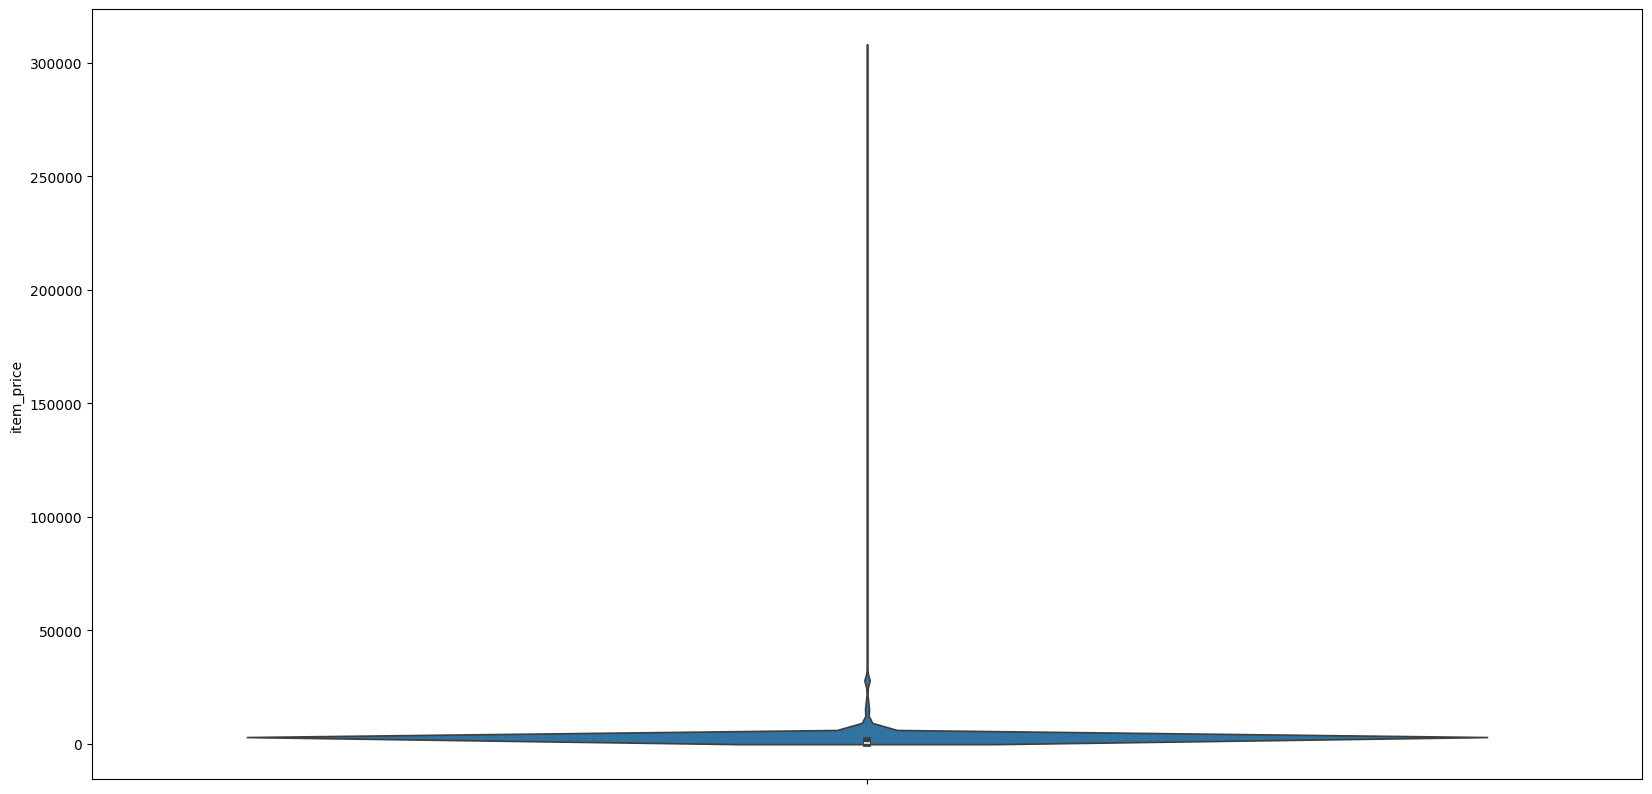

In [21]:
fig,ax = plt.subplots(figsize = (20,10))
sns.violinplot(train.item_price)

In [22]:
train[train.item_price > 250000]


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,2013-12-13,11,12,6066,307980.000,1.000


In [23]:
train[train.item_id == 6066]


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,2013-12-13,11,12,6066,307980.000,1.000


In [24]:
train.drop(1163158,inplace = True)


In [25]:
train_1['year_month'] = train_1.index.strftime('%Y-%m')


In [26]:


df = pd.pivot_table(train_1, index = ['shop_id','item_id'], 
                              columns = 'year_month',
                              values = 'item_cnt_day',
                              aggfunc = np.sum,
                              fill_value = 0)
df = df.reset_index().rename_axis(None,axis = 1)
df

,shop_id,item_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0,30,0.000,31.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0,31,0.000,11.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0,32,6.000,10.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0,33,3.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0,35,1.000,14.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424119,59,22154,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
424120,59,22155,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
424121,59,22162,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,9.000,4.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000
424122,59,22164,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,2.000,1.000,2.000,0.000,0.000,1.000,0.000,0.000,0.000


In [27]:
df_test = test.merge(df, on = ['shop_id','item_id'],how = 'left').fillna(0).drop(columns = 'ID')

# drop redundant columns for df_test
df_test = df_test.drop(columns = ['shop_id','item_id'])
df_test.head()

,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,2.000,0.000,0.000,0.000,1.000,1.000,1.000,3.000,1.000,0.000
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,3.000,2.000,0.000,1.000,3.000,1.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [28]:
df_test_train = df_test.iloc[:,:-1]
df_test_val = df_test.iloc[:,-1]

In [29]:
print(f'validation set: {df_test_val.shape}')
print(f'train set: {df_test_train.shape}')

validation set: (214200,)
train set: (214200, 33)


In [30]:
X = df_test_train
y = df_test_val
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle = False,test_size = 0.2, random_state = 42)

In [31]:
print(f'train: {X.shape}')
print(f'test: {y.shape}')
print(f'val train: {X_test.shape}')
print(f'val test: {y_test.shape}')

train: (214200, 33)
test: (214200,)
val train: (42840, 33)
val test: (42840,)


In [32]:
ss = StandardScaler()
ss.fit(X_train)
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

In [33]:
def get_models(models=dict()):
# linear models
    models['lr'] = LinearRegression()
    models['lasso'] = Lasso()
    models['ridge'] = Ridge()
    models['en'] = ElasticNet()
    models['huber'] = HuberRegressor()
    models['pa'] = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
   
    return models

def get_models_nl(models=dict()):
# non-linear models
    models['svr'] = SVR()
# ensemble models
    n_trees = 100
    models['ada'] = AdaBoostRegressor(n_estimators=n_trees)
    models['bag'] = BaggingRegressor(n_estimators=n_trees)
    models['rf'] = RandomForestRegressor(n_estimators=n_trees)
    models['et'] = ExtraTreesRegressor(n_estimators=n_trees)
    models['gbm'] = GradientBoostingRegressor(n_estimators=n_trees)
    return models

def pipeline(model):
    pipe = Pipeline([(model, model_dict[model])])
    return pipe

def params(model):
    

    if model == 'lasso':
        return {"alpha":[0.01,0.1,1,2,5,10],
               }
    
    
    elif model == 'ridge':
        return {
            "alpha":[0.01,0.1,1,2,5,10],
            }
    
    elif model == 'en':
        return {
            'alpha':[0.01,0.1,1,10],
            'l1_ratio':[0.2,0.3,0.4,0.5,0.6]
            }
    elif model == 'knn':
        return {
            'n_neighbors':[4,5,6,7]}

    elif model == 'dt':
        return {
            'max_depth':[3,4,5],
            'min_samples_split':[2,3,4],
            'min_samples_leaf':[2,3,4]
        }
    elif model == 'bag':
        return {
            'max_features':[100, 150]
        }
        
    elif model == 'rf':
        return {
            'n_estimators':[100,150],
            'max_depth':[4],
            'min_samples_leaf':[2,3,4]
        }
    elif model == 'et':
        return {
            'n_estimators':[50,100,150],
            'max_depth':[5],
            'min_samples_leaf':[2,3],
        }
    elif model == 'abc':
        return {
            'n_estimators':[50, 100,150],
            'learning_rate':[0.3,0.6,1]
        }
    elif model == 'gbc':
        return {
            'learning_rate':[0.2],
            'max_depth':[5],
            'min_samples_split':[2,5]
            
        }
    elif model == 'xgb':
        return {
            'eval_metric' : ['auc'],
            'subsample' : [0.8], 
            'colsample_bytree' : [0.5], 
            'learning_rate' : [0.1],
            'max_depth' : [5], 
            'scale_pos_weight': [5], 
            'n_estimators' : [100,200],
            'reg_alpha' : [0, 0.05],
            'reg_lambda' : [2,3],
            'gamma' : [0.01]
                             
        }
    elif model == 'svr':
        return {
            'kernel': ['rbf', 'linear','poly'], 
            'C': [1,20,50,100],
            'gamma':['scale','auto'],
            'epsilon':[0.1,1,10]
        }
    elif model == 'ada':
        return {
            'n_estimators':[50,100,150],
            'learning_rate':[0.01,0.1,1],
            
        }
    elif model == 'bag':
        return {
            'n_estimators':[20,50,100,150],
            'max_features':[5,10,20],
            'max_samples':[0.1,0.2,0.3,0.5,0.7],
            'bootstrap':[True]
            
        }
    elif model == 'rf':
        return {
             'bootstrap': [True],
             'max_depth': [5,10,20],
             'max_features': ["auto", "sqrt", "log2"],
             'min_samples_leaf': [2,4,6,8,10],
             'min_samples_split': [2,5,8,10],
             'n_estimators': [50,200,300,400],
             'random_state': 42,
             }
    elif model == 'et':
        return {
             'bootstrap': [True],
             'max_depth': [5,10,20],
             'max_features': ["auto", "sqrt", "log2"],
             'min_samples_leaf': [2,4,6,8,10],
             'min_samples_split': [2,5,8,10],
             'n_estimators': [50,200,300,400],
             'random_state': 42,
        }
            
    elif model == 'gbm':
        return {
            'learning_rate' : [0.1,0.3,0.6,1], 
            'min_samples_split':[500,1000,2000,3000,5000],
            'min_samples_leaf': [50,200,400,1000],
            'max_depth' : [8,10,20,30]
        }

In [34]:
def evaluate_models(models, X_train_ss,y_train,X_test_ss,y_test):
    for name, model in models.items():
    # fit models
        model_fit = model.fit(X_train_ss,y_train)
        # make predictions
        train_preds = model_fit.predict(X_train_ss)
        test_preds = model_fit.predict(X_test_ss)
        # evaluate forecast
        train_mse = mean_squared_error(y_train,train_preds)
        test_mse = mean_squared_error(y_test,test_preds)
        print(f'{name}:')
        print(f'----')
        print(f'Train MAE: {round(train_mse,2)}')
        print(f'Test MAE: {round(test_mse,2)}')
        print(f'\n')
    

In [35]:
def grid_search(model,models,X_train = X_train_ss,y_train = y_train,X_test = X_test_ss,y_test=y_test):
    pipe_params = params(model)
    model = models[model]
    gs = GridSearchCV(model,param_grid = pipe_params,cv = 5,scoring = 'neg_mean_squared_error', verbose=True, n_jobs=8)
    gs.fit(X_train_ss,y_train)
    train_score = gs.score(X_train_ss,y_train)
    test_score = gs.score(X_test_ss,y_test)
    
    print(f'Results from: {model}')
    print(f'-----------------------------------')
    print(f'Best Hyperparameters: {gs.best_params_}')
    print(f'Mean MSE: {round(gs.best_score_,4)}')
    print(f'Train Score: {round(train_score,4)}')
    print(f'Test Score: {round(test_score,4)}')
    print(' ')

In [36]:
def grid_search_rs(model,models,X_train = X_train_ss,y_train = y_train,X_test = X_test_ss,y_test=y_test):
    pipe_params = params(model)
    model = models[model]
    gs = RandomizedSearchCV(model,param_distributions = pipe_params,cv = 5,scoring = 'neg_mean_squared_error', verbose=True, n_jobs=8)
    gs.fit(X_train_ss,y_train)
    train_score = gs.score(X_train_ss,y_train)
    test_score = gs.score(X_test_ss,y_test)
    
    print(f'Results from: {model}')
    print(f'-----------------------------------')
    print(f'Best Hyperparameters: {gs.best_params_}')
    print(f'Mean MSE: {round(gs.best_score_,4)}')
    print(f'Train Score: {round(train_score,4)}')
    print(f'Test Score: {round(test_score,4)}')
    print(' ')

In [37]:
models = get_models()
evaluate_models(models,X_train_ss,y_train,X_test_ss,y_test)

lr:
----
Train MAE: 17.96
Test MAE: 3.32


lasso:
----
Train MAE: 24.46
Test MAE: 1.01


ridge:
----
Train MAE: 17.96
Test MAE: 3.32


en:
----
Train MAE: 24.51
Test MAE: 0.88


huber:
----
Train MAE: 32.24
Test MAE: 0.83


pa:
----
Train MAE: 28.74
Test MAE: 1.97




In [38]:
%time grid_search('lasso',models)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Results from: Lasso()
-----------------------------------
Best Hyperparameters: {'alpha': 0.1}
Mean MSE: -31.5447
Train Score: -19.0354
Test Score: -1.9192
 
CPU times: total: 52.2 s
Wall time: 1min 18s


In [39]:
%%time
grid_search_rs('lasso',models)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Results from: Lasso()
-----------------------------------
Best Hyperparameters: {'alpha': 0.1}
Mean MSE: -31.5447
Train Score: -19.0354
Test Score: -1.9192
 
CPU times: total: 35.1 s
Wall time: 36.8 s


In [40]:
%time grid_search_rs('en',models)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Results from: ElasticNet()
-----------------------------------
Best Hyperparameters: {'l1_ratio': 0.4, 'alpha': 0.1}
Mean MSE: -31.2047
Train Score: -18.9587
Test Score: -1.9236
 
CPU times: total: 32.9 s
Wall time: 1min 7s


In [41]:
%time grid_search('en',models)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Results from: ElasticNet()
-----------------------------------
Best Hyperparameters: {'alpha': 0.1, 'l1_ratio': 0.2}
Mean MSE: -31.1294
Train Score: -18.9416
Test Score: -1.9402
 
CPU times: total: 20.5 s
Wall time: 2min


In [42]:
X_train_ss.shape


(171360, 33)

In [43]:
X_train_ss_rs = X_train_ss.reshape((X_train_ss.shape[0],X_train_ss.shape[1],1))
X_test_ss_rs = X_test_ss.reshape((X_test_ss.shape[0],X_test_ss.shape[1],1))
ss1 = StandardScaler()
ss1.fit(y_train.values.reshape(y_train.shape[0],1))
y_train_ss = ss1.transform(y_train.values.reshape(y_train.shape[0],1))

Epoch 1/30
4/4 - 28s - 7s/step - loss: 0.0906
Epoch 2/30
4/4 - 17s - 4s/step - loss: 0.0687
Epoch 3/30
4/4 - 19s - 5s/step - loss: 0.0648
Epoch 4/30
4/4 - 20s - 5s/step - loss: 0.0602
Epoch 5/30
4/4 - 29s - 7s/step - loss: 0.0571
Epoch 6/30
4/4 - 39s - 10s/step - loss: 0.0569
Epoch 7/30
4/4 - 36s - 9s/step - loss: 0.0554
Epoch 8/30
4/4 - 20s - 5s/step - loss: 0.0553
Epoch 9/30
4/4 - 21s - 5s/step - loss: 0.0541
Epoch 10/30
4/4 - 20s - 5s/step - loss: 0.0534
Epoch 11/30
4/4 - 25s - 6s/step - loss: 0.0528
Epoch 12/30
4/4 - 40s - 10s/step - loss: 0.0522
Epoch 13/30
4/4 - 38s - 10s/step - loss: 0.0520
Epoch 14/30
4/4 - 21s - 5s/step - loss: 0.0511
Epoch 15/30
4/4 - 22s - 5s/step - loss: 0.0507
Epoch 16/30
4/4 - 18s - 4s/step - loss: 0.0504
Epoch 17/30
4/4 - 32s - 8s/step - loss: 0.0507
Epoch 18/30
4/4 - 39s - 10s/step - loss: 0.0496
Epoch 19/30
4/4 - 20s - 5s/step - loss: 0.0491
Epoch 20/30
4/4 - 23s - 6s/step - loss: 0.0485
Epoch 21/30
4/4 - 48s - 12s/step - loss: 0.0480
Epoch 22/30
4/4 -

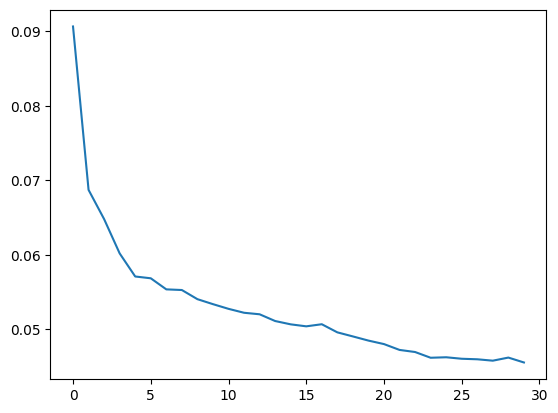

In [44]:
%%time
model = Sequential()
model.add(LSTM(50, input_shape = (X_train_ss_rs.shape[1],X_train_ss_rs.shape[2]),activation = 'relu'))
model.add(Dense(16,activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(1))
model.compile(loss = 'mae',optimizer = 'adam')
history = model.fit(X_train_ss_rs,y_train_ss,epochs = 30, batch_size = 50000, verbose = 2,shuffle = False)
plt.plot(history.history['loss'],label = 'loss')

Epoch 1/50
2/2 - 28s - 14s/step - loss: 0.1072
Epoch 2/50
2/2 - 43s - 21s/step - loss: 0.0942
Epoch 3/50
2/2 - 39s - 20s/step - loss: 0.0920
Epoch 4/50
2/2 - 28s - 14s/step - loss: 0.0835
Epoch 5/50
2/2 - 33s - 17s/step - loss: 0.0766
Epoch 6/50
2/2 - 20s - 10s/step - loss: 0.0755
Epoch 7/50
2/2 - 23s - 12s/step - loss: 0.0732
Epoch 8/50
2/2 - 37s - 18s/step - loss: 0.0733
Epoch 9/50
2/2 - 24s - 12s/step - loss: 0.0706
Epoch 10/50
2/2 - 18s - 9s/step - loss: 0.0692
Epoch 11/50
2/2 - 20s - 10s/step - loss: 0.0678
Epoch 12/50
2/2 - 20s - 10s/step - loss: 0.0660
Epoch 13/50
2/2 - 20s - 10s/step - loss: 0.0658
Epoch 14/50
2/2 - 18s - 9s/step - loss: 0.0655
Epoch 15/50
2/2 - 19s - 10s/step - loss: 0.0640
Epoch 16/50
2/2 - 17s - 9s/step - loss: 0.0630
Epoch 17/50
2/2 - 17s - 9s/step - loss: 0.0626
Epoch 18/50
2/2 - 17s - 8s/step - loss: 0.0620
Epoch 19/50
2/2 - 16s - 8s/step - loss: 0.0609
Epoch 20/50
2/2 - 18s - 9s/step - loss: 0.0612
Epoch 21/50
2/2 - 18s - 9s/step - loss: 0.0598
Epoch 22/

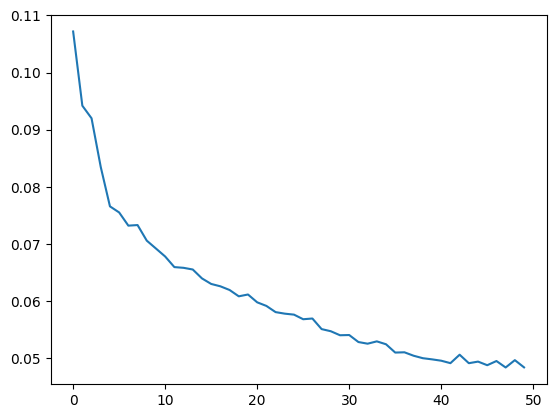

In [45]:
%%time
model_1 = Sequential()
# [samples,timesteps,features]
model_1.add(LSTM(50, input_shape = (X_train_ss_rs.shape[1],X_train_ss_rs.shape[2]),activation = 'relu'))
model_1.add(Dense(16,activation = 'relu'))
model_1.add(Dropout(0.4))
model_1.add(Dense(1))
model_1.compile(loss = 'mae',optimizer = 'adam')
history_1 = model_1.fit(X_train_ss_rs,y_train_ss,epochs = 50, batch_size = 100000, verbose = 2,shuffle = False)
plt.plot(history_1.history['loss'],label = 'loss')

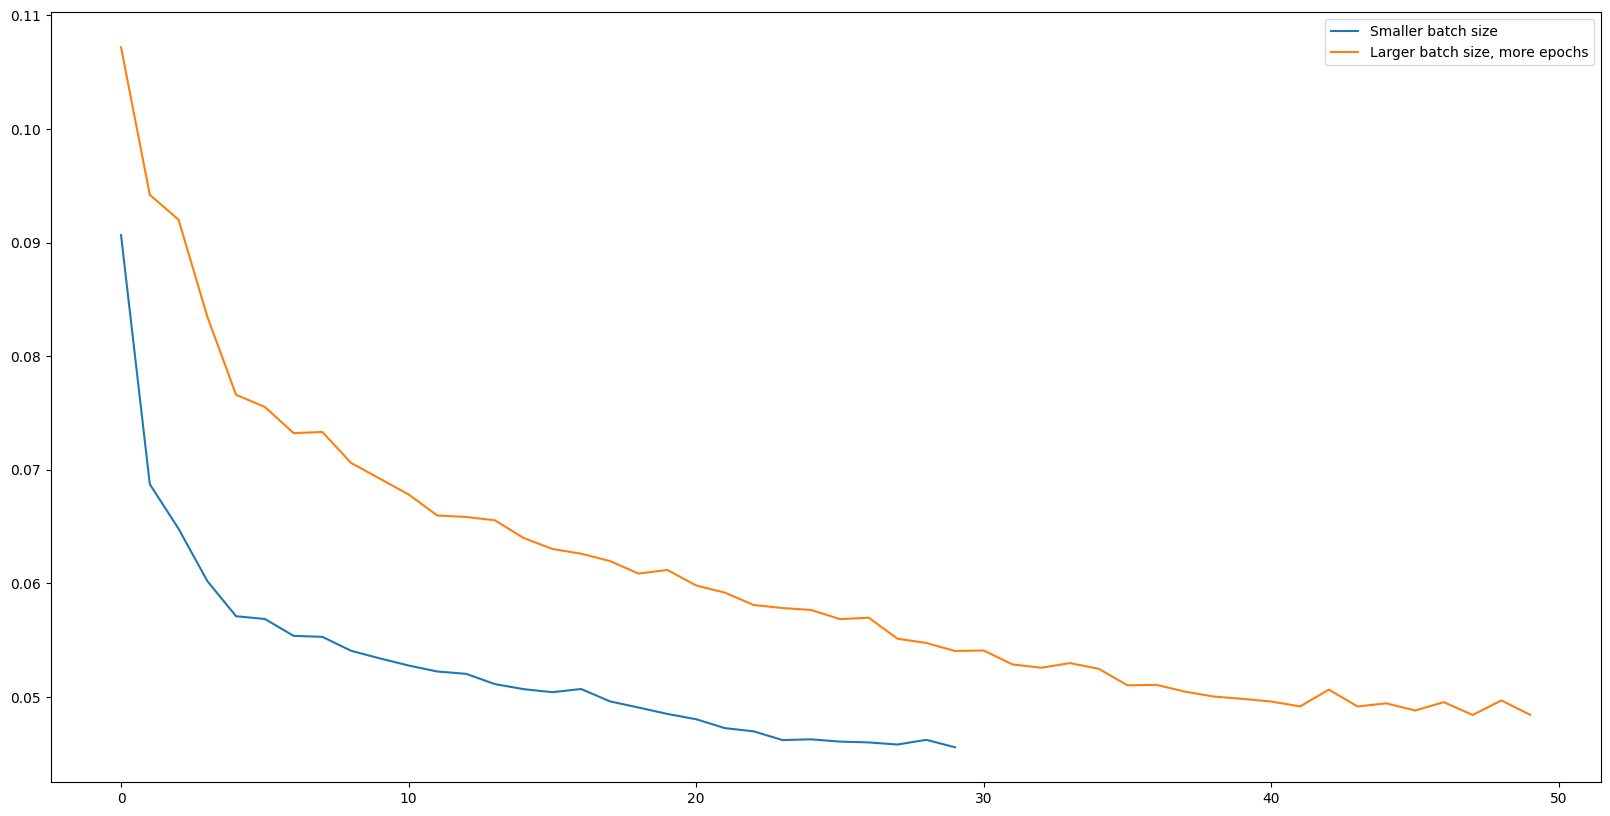

In [46]:
fig,ax = plt.subplots(figsize = (20,10))
ax.plot(history.history['loss'],label = 'Smaller batch size')
ax.plot(history_1.history['loss'],label = 'Larger batch size, more epochs')
# ax.plot(history_2.history['loss'],label = 'Larger batch size, more epochs, no relu')
plt.legend()

In [47]:
def mae_train_test(model,model_name, X_train,y_train,X_test,y_test,ss1):
    trainpreds = ss1.inverse_transform(model.predict(X_train)).reshape((y_train.shape[0],))
    testpreds = ss1.inverse_transform(model.predict(X_test)).reshape((y_test.shape[0],))
    print(f'Model: {model_name}')
    print('----')
    print(f'Train MAE: {mean_squared_error(y_train,trainpreds)}')
    print(f'Test MAE: {mean_squared_error(y_test,testpreds)}')
    print('\n')

In [48]:
mae_train_test(model,"LSTM - Smaller Batch Size", X_train_ss_rs,y_train,X_test_ss_rs,y_test,ss1)
mae_train_test(model_1,"LSTM - Larger Batch Size, more epochs", X_train_ss_rs,y_train,X_test_ss_rs,y_test,ss1)

5355/5355 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step
Model: LSTM - Smaller Batch Size
----
Train MAE: 29.40786643842791
Test MAE: 0.7446615476144801


5355/5355 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step
Model: LSTM - Larger Batch Size, more epochs
----
Train MAE: 30.97946909461017
Test MAE: 0.848526355644942




In [49]:
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')

Shape of X_train: (171360, 33)
Shape of X_test: (42840, 33)


In [50]:
subseq = 1
ts = 33
ss_cnn = StandardScaler()
ss_cnn.fit(X_train)
X_train_sub = ss_cnn.transform(X_train).reshape((X_train.shape[0],subseq,ts,1))
X_test_sub = ss_cnn.transform(X_test).reshape((X_test.shape[0],subseq,ts,1))
print(f'Shape of X_train_sub: {X_train_sub.shape}')
print(f'Shape of X_test_sub: {X_test_sub.shape}')

Shape of X_train_sub: (171360, 1, 33, 1)
Shape of X_test_sub: (42840, 1, 33, 1)


In [51]:
%%time 
cnn_lstm = Sequential()
cnn_lstm.add(TimeDistributed(Conv1D(filters = 64, kernel_size = 2, input_shape = (None,X_train_sub.shape[2],X_train_sub.shape[3]),activation = 'relu')))
cnn_lstm.add(TimeDistributed(Dropout(0.4)))
cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size = 1)))
cnn_lstm.add(TimeDistributed(Flatten()))
cnn_lstm.add(LSTM(50, activation = 'relu',return_sequences = True))
cnn_lstm.add(Dense(16,activation = 'relu'))
cnn_lstm.add(Dropout(0.4))
cnn_lstm.add(Dense(1))
cnn_lstm.compile(loss= 'mae',optimizer = 'adam')
cnn_lstm_history = cnn_lstm.fit(X_train_sub,y_train_ss, epochs = 50, batch_size = 100000, verbose = 2,shuffle = False)

Epoch 1/50
2/2 - 44s - 22s/step - loss: 0.0876
Epoch 2/50
2/2 - 15s - 8s/step - loss: 0.0682
Epoch 3/50
2/2 - 23s - 12s/step - loss: 0.0643
Epoch 4/50
2/2 - 20s - 10s/step - loss: 0.0629
Epoch 5/50
2/2 - 15s - 8s/step - loss: 0.0590
Epoch 6/50
2/2 - 21s - 11s/step - loss: 0.0591
Epoch 7/50
2/2 - 16s - 8s/step - loss: 0.0583
Epoch 8/50
2/2 - 12s - 6s/step - loss: 0.0564
Epoch 9/50
2/2 - 13s - 7s/step - loss: 0.0563
Epoch 10/50
2/2 - 13s - 7s/step - loss: 0.0565
Epoch 11/50
2/2 - 17s - 9s/step - loss: 0.0555
Epoch 12/50
2/2 - 15s - 7s/step - loss: 0.0544
Epoch 13/50
2/2 - 12s - 6s/step - loss: 0.0549
Epoch 14/50
2/2 - 16s - 8s/step - loss: 0.0542
Epoch 15/50
2/2 - 15s - 7s/step - loss: 0.0544
Epoch 16/50
2/2 - 17s - 8s/step - loss: 0.0541
Epoch 17/50
2/2 - 17s - 8s/step - loss: 0.0536
Epoch 18/50
2/2 - 12s - 6s/step - loss: 0.0532
Epoch 19/50
2/2 - 13s - 7s/step - loss: 0.0526
Epoch 20/50
2/2 - 17s - 9s/step - loss: 0.0534
Epoch 21/50
2/2 - 18s - 9s/step - loss: 0.0526
Epoch 22/50
2/2 - 

In [52]:
%%time
cnn_lstm_1 = Sequential()
cnn_lstm_1.add(TimeDistributed(Conv1D(filters = 64, kernel_size = 11, input_shape = (None,1,X_train_sub.shape[2],X_train_sub.shape[3]),activation = 'relu')))
cnn_lstm_1.add(TimeDistributed(Dropout(0.4)))
cnn_lstm_1.add(TimeDistributed(MaxPooling1D(pool_size = 1)))
cnn_lstm_1.add(TimeDistributed(Flatten()))
cnn_lstm_1.add(LSTM(50, activation = 'relu'))
cnn_lstm_1.add(Dense(16))
cnn_lstm_1.add((Dropout(0.4)))
cnn_lstm_1.add(Dense(1))
cnn_lstm_1.compile(loss= 'mae',optimizer = 'adam')
cnn_lstm_1_history = cnn_lstm_1.fit(X_train_sub,y_train_ss, epochs = 30, batch_size = 100000, verbose = 2,shuffle = False)

Epoch 1/30
2/2 - 23s - 11s/step - loss: 0.0848
Epoch 2/30
2/2 - 9s - 4s/step - loss: 0.0634
Epoch 3/30
2/2 - 11s - 5s/step - loss: 0.0655
Epoch 4/30
2/2 - 21s - 10s/step - loss: 0.0592
Epoch 5/30
2/2 - 12s - 6s/step - loss: 0.0589
Epoch 6/30
2/2 - 19s - 9s/step - loss: 0.0580
Epoch 7/30
2/2 - 12s - 6s/step - loss: 0.0562
Epoch 8/30
2/2 - 20s - 10s/step - loss: 0.0562
Epoch 9/30
2/2 - 14s - 7s/step - loss: 0.0556
Epoch 10/30
2/2 - 14s - 7s/step - loss: 0.0553
Epoch 11/30
2/2 - 16s - 8s/step - loss: 0.0546
Epoch 12/30
2/2 - 19s - 10s/step - loss: 0.0538
Epoch 13/30
2/2 - 11s - 5s/step - loss: 0.0532
Epoch 14/30
2/2 - 12s - 6s/step - loss: 0.0534
Epoch 15/30
2/2 - 13s - 7s/step - loss: 0.0529
Epoch 16/30
2/2 - 11s - 6s/step - loss: 0.0527
Epoch 17/30
2/2 - 12s - 6s/step - loss: 0.0528
Epoch 18/30
2/2 - 12s - 6s/step - loss: 0.0522
Epoch 19/30
2/2 - 25s - 13s/step - loss: 0.0517
Epoch 20/30
2/2 - 16s - 8s/step - loss: 0.0527
Epoch 21/30
2/2 - 20s - 10s/step - loss: 0.0523
Epoch 22/30
2/2 -

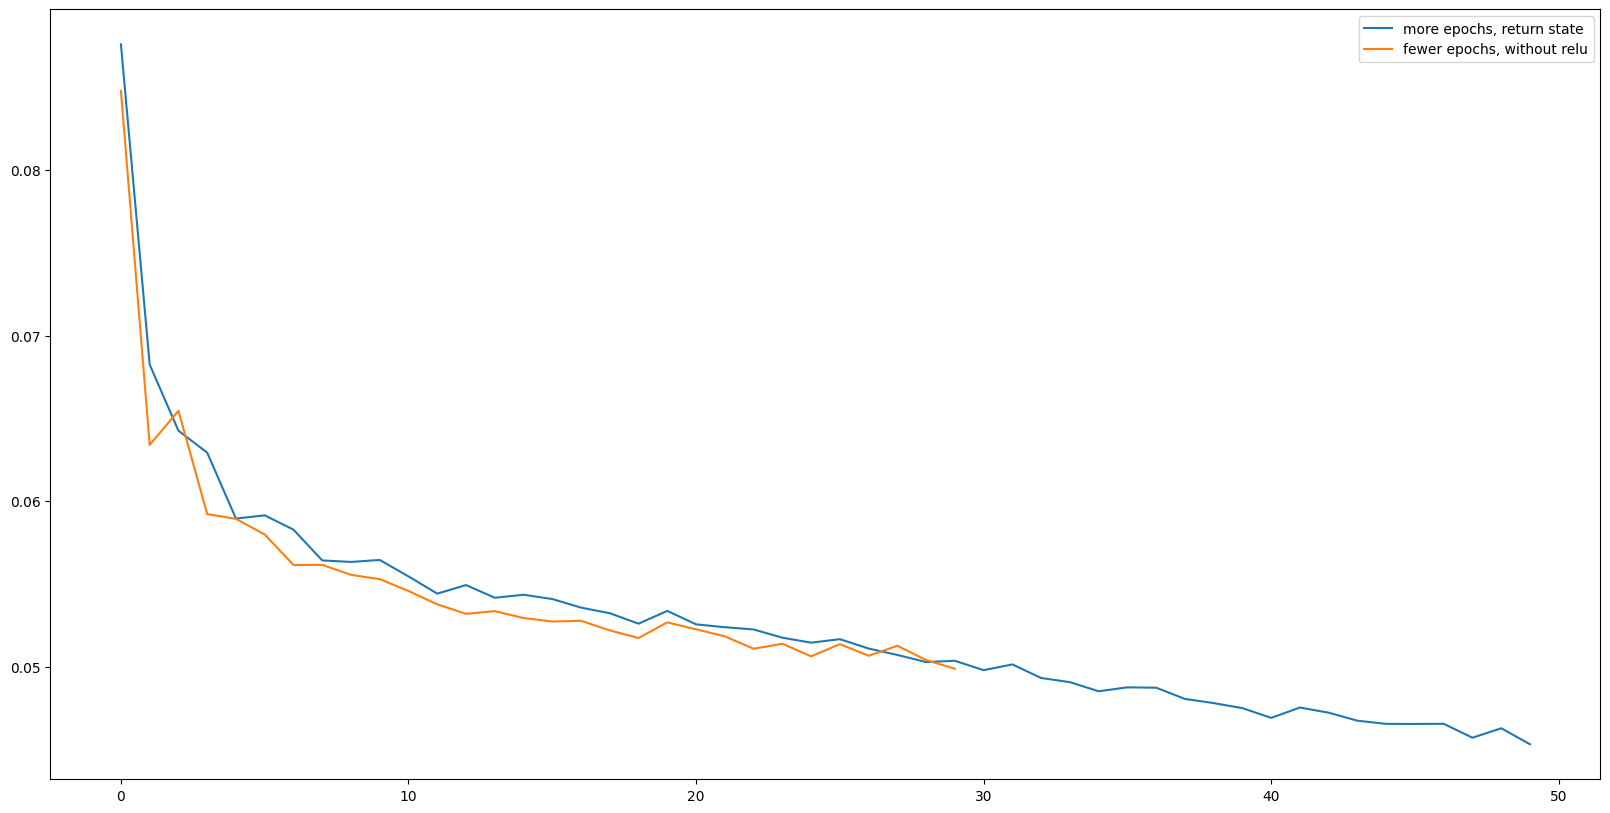

In [53]:
fig,ax = plt.subplots(figsize = (20,10))
ax.plot(cnn_lstm_history.history['loss'],label = 'more epochs, return state')
ax.plot(cnn_lstm_1_history.history['loss'],label = 'fewer epochs, without relu')
ax.legend()

In [56]:
def mae_train_test(model, model_name, X_train, y_train, X_test, y_test, ss1):
    # Tahminleri al ve zaman boyutunu sıkıştır (son zaman adımını al)
    train_preds = model.predict(X_train)[:, -1, :]  # Son zaman adımını seç
    test_preds = model.predict(X_test)[:, -1, :]    # Son zaman adımını seç

    # Standartlaştırılmış veriyi ters çevir
    train_preds = ss1.inverse_transform(train_preds)
    test_preds = ss1.inverse_transform(test_preds)

    # Şekli uyumlu hale getir
    train_preds = train_preds.reshape((y_train.shape[0],))
    test_preds = test_preds.reshape((y_test.shape[0],))

    # MAE hesapla
    train_mae = np.mean(np.abs(train_preds - y_train))
    test_mae = np.mean(np.abs(test_preds - y_test))

    print(f"Model: {model_name}")
    print(f"Train MAE: {train_mae}")
    print(f"Test MAE: {test_mae}")


In [58]:
def mae_train_test(model, model_name, X_train, y_train, X_test, y_test, ss1):
    # Tahminleri al (direkt olarak 2D veri)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # Standartlaştırılmış veriyi ters çevir
    train_preds = ss1.inverse_transform(train_preds)
    test_preds = ss1.inverse_transform(test_preds)

    # Şekli uyumlu hale getir
    train_preds = train_preds.reshape((y_train.shape[0],))
    test_preds = test_preds.reshape((y_test.shape[0],))

    # MAE hesapla
    train_mae = np.mean(np.abs(train_preds - y_train))
    test_mae = np.mean(np.abs(test_preds - y_test))

    print(f"Model: {model_name}")
    print(f"Train MAE: {train_mae}")
    print(f"Test MAE: {test_mae}")


In [59]:
print(f'test: {df_test.shape}')
print(f'train: {df.shape}')

test: (214200, 34)
train: (424124, 36)


In [60]:
df_test_1 = df_test.iloc[:,1:]
ss_test = StandardScaler()
ss_test.fit(df_test_1)
df_test_1_sub = ss_test.transform(df_test_1).reshape((df_test_1.shape[0],subseq,ts,1))

In [61]:
df_test_1.shape


(214200, 33)

In [62]:
print(f'Shape of test: {df_test_1_sub.shape}')


Shape of test: (214200, 1, 33, 1)


In [63]:
preds = cnn_lstm_1.predict(df_test_1_sub)


6694/6694 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step


In [64]:
forecasts = np.zeros(shape=(len(preds), 33) )
# replace the first column with the actual preds
forecasts[:,0] = preds[:,0]
# inverse transform and then select the same preds column
forecasts = ss_test.inverse_transform(forecasts)[:,0]

In [65]:
submissions = pd.DataFrame({"ID":test.ID, "item_cnt_month":forecasts})
submissions.head()

,ID,item_cnt_month
0,0,0.083
1,1,0.046
2,2,0.104
3,3,0.047
4,4,0.046


In [66]:
submissions.to_csv('submissions.csv',index = False)